Historical weather data from Basel is used to predict the amount of *Short wave radiation* on a hourly basis. The data covers 1863 days from 07/2013 to 07/2018. The model is tested on data from 07/2012 to 07/2013.


The input variables used were,

* Hour of day (0-24)
* Temperature (2m above ground)
* Relative Humidity (2m above ground)


This notebook walksthrough the data processing and modelling done for this task. Data can be found [here](https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604?daterange=2013-07-19+to+2018-07-18&params=&params%5B%5D=11%3B2+m+above+gnd&params%5B%5D=52%3B2+m+above+gnd&params%5B%5D=71%3Bsfc&params%5B%5D=204%3Bsfc&utc_offset=2&aggregation=hourly&temperatureunit=CELSIUS&windspeedunit=KILOMETER_PER_HOUR).

In [3]:
# -*- coding: utf-8 -*-
from numpy.random import seed
seed(42)

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K

For building the model I use the keras scikit-learn API. While this API constrains us to single input models, it does feel familiar to anyone already acustomed to this interface and provides all the expected functionality.


I am using the tensorflow backend for keras (this is also the default setting) and have not used GPU accelaration for this model. This code will work regardless if anyone does run it on any other backend.


**Note** keras version 2.1.4 was used

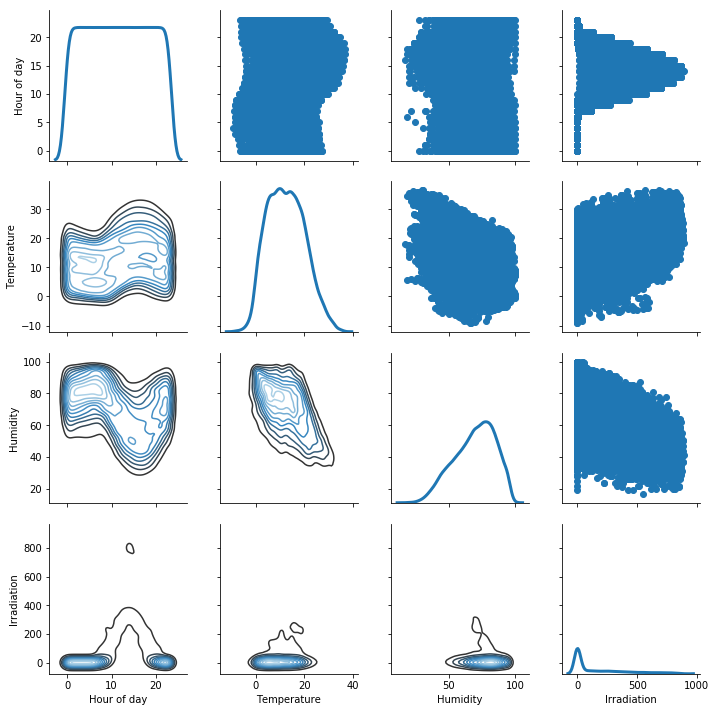

In [4]:
# Import data

data = pd.read_csv("./data/history_export_2018-07-19T13_39_29.csv", header=None).astype(float)
data.drop([0,1,2,4,7], axis=1, inplace=True)
data.rename({3: 'Hour of day', 5: 'Temperature', 6: 'Humidity', 8: 'Irradiation'}, axis = 'columns', inplace=True)

grid = sns.PairGrid(data)
grid = grid.map_upper(plt.scatter)
grid = grid.map_lower(sns.kdeplot, cmap="Blues_d")
grid = grid.map_diag(sns.kdeplot, lw=3, legend=False)
plt.show()

The grid plot shows us the distribution of each variable on the diagonal. Above the diagonal are the pair-wise scatterplots. Below the diagonal are the pairwise density plots.


From the grid plot is is quite evident that the data in its current form cannot be used to model the relationship between Hour, Temparature and Humidity with Irradiation in any meaningful way. 


**This is because the predicitve variables are not correlated with Irradiation at all!**

It is interesting to see that for the variable *Hour of day*, Irradiation is zero at early and later hours probably corresponding to the daylight cycle. As it turns out, short wave radiation only occurs during daylight hours so we can safely remove the rows corresponding to darkness.


**This is okay, since the during darkness Irradiation is always zero, thus the relationship is trivial (and known) therefore we can focus the modelling effort on the daylight hours only!**

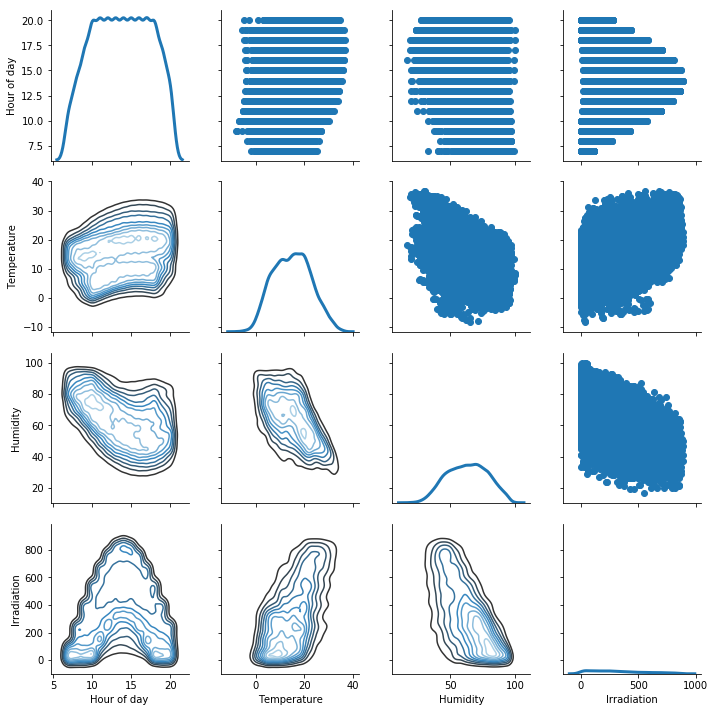

In [5]:
# Dropping zero values irradiation

data = data.loc[~data['Hour of day'].isin([0,1,2,3,4,5,6,21,22,23])]
data = data.apply(lambda x: x.replace(0.0, np.nan)).dropna(how='any', axis=0)

grid = sns.PairGrid(data)
grid = grid.map_upper(plt.scatter)
grid = grid.map_lower(sns.kdeplot, cmap="Blues_d")
grid = grid.map_diag(sns.kdeplot, lw=3, legend=False)
plt.show()

**After dropping all rows with Irradiation value of zero, we can see that the predictive variables can now be used to predict Irradiation during daylight hours.**

It is also obvious that methods assuming that the data is distributed normally are not applicable in this case. This is not a problem with the neural network model which doesn't have such assumptions. It will also handle non-linear interactions but the challenge for us is to prevent overfitting!

**We will use a custom metric function to monitor our model that is based on the pearson correlation. Ultimately, we only care about modelling the relationship between the predictive variables and Irradiation. The absolute values can be obtained easily as long as the output is linearly associated with the real values.**

In [6]:
# Custom metric function

def correlation_coefficient_metric(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(np.multiply(xm,ym))
    r_den = K.sqrt(np.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return r

**We will split the data into validation and training sets in a 9:1 ratio.**

In [7]:
# Split into input (X) and output (Y) variables

X = data.iloc[:,0:3]
Y = data.iloc[:,3]

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.10, shuffle=True, random_state=0)

**Finally we set up and train the model.** 

The values for number of iterations, optimizer, loss and metric are ones that worked best for me. There are many more options that could be tested to improve the model. The scikit-learn API allows easy usage of the grid search function and can be a great tool to use here as the data is not that big or complex.


In [8]:
# Choose values that are suitable

num_epochs  = 1000
opt = Adam()
loss_f = 'mse'
metric = correlation_coefficient_metric

# Create model

model = Sequential()

model.add(Dense(27, input_dim=3, activation='relu', bias_initializer = 'RandomNormal'))
model.add(Dense(27, activation='relu'))
model.add(Dense(9, activation='relu'))

model.add(Dense(1, activation = 'relu'))

# Compile model

model.compile(loss=loss_f, optimizer= opt, metrics = [metric])

# Train the model

hist = model.fit(x_train ,y_train, batch_size = 200, epochs=num_epochs, shuffle=True, verbose=0)

# Plotting loss

train_loss=hist.history['loss']

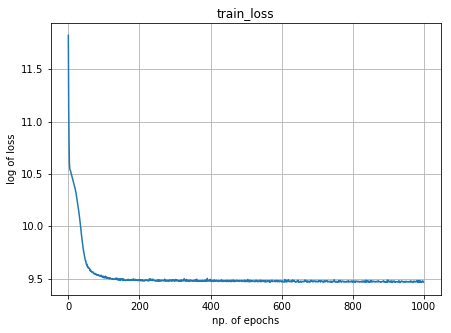

In [9]:
plt.figure(1, figsize=(7,5))
plt.plot(range(num_epochs), np.log(train_loss))
plt.xlabel('np. of epochs')
plt.ylabel('log of loss')
plt.title('train_loss')
plt.grid(True)
plt.show()

**The plot shows us that the loss goes down quite rapidly upto the 200th epoch and starts to stabilise afterwards.** 

The choice of optimiser has a very strong effect on the rate of learning. Here we used the Adam optimiser with no decay in the learning rate.

In [10]:
# Validation

score = model.evaluate(x_val, y_val)

print('Correlation between actual and predicted values for validation data: %s \n' % score[1])

2214/2214 [==============================] - 0s 16us/step
Correlation between actual and predicted values for validation data: 0.8685066635369608 



**We get a very good correlation value between the actual and predicted Irradiation.**

The validation data was selected randomly from the testing data and therefore contains samples from different years and hour of day. This is a good sign that our model works!

However it is better to test the model on a different dataset. **The test data used here comes from the timeframe 07/2012-07/2013 and thus does not have any samples from the years we trained the model on.**

4424/4424 [==============================] - 0s 10us/step
Correlation between actual and predicted values for testing data: 0.8685066635369608 



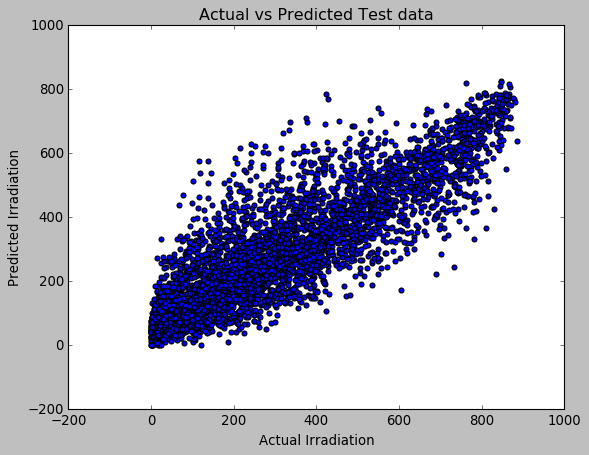

In [12]:
# Testing

tdata = pd.read_csv("./data/history_export_2018-07-19T17_56_33.csv", header=None).astype(float)
tdata.drop([0,1,2,4,7], axis=1, inplace=True)
tdata.rename({3: 'Hour of day', 5: 'Temperature', 6: 'Humidity', 8: 'Irradiation'}, axis = 'columns', inplace=True)
tdata = tdata.loc[~tdata['Hour of day'].isin([0,1,2,3,4,5,6,21,22,23])]
tdata = tdata.apply(lambda x: x.replace(0.0, np.nan)).dropna(how='any', axis=0)

X_test = tdata.iloc[:,0:3]
Y_test = tdata.iloc[:,3]

predictions = model.predict(X_test)

tscore = model.evaluate(X_test, Y_test)

print('Correlation between actual and predicted values for testing data: %s \n' % score[1])

plt.scatter(Y_test, predictions)
plt.xlabel('Actual Irradiation')
plt.ylabel('Predicted Irradiation')
plt.title('Actual vs Predicted Test data')
plt.style.use(['classic'])

**We again get a good correlation value between the actual and predicted Irradiation for the test set.**

From the plot, we can see that the predicted and actual values have a linear dependance but for some values the predictions can be quite wrong!

One adjustment that can be made is to regress the predicted values on the original values and adjust the predicted values to obtain scaled predictions that belong to the distribution of the actual data. This is not particularly useful in the testing dataset and makes predcitions worse in certain cases.

Though for the validation set, this was quite useful!

Slope and intercept of the regression model between predicted and actual Irradiation:  0.7054532344313262 73.82785172115825


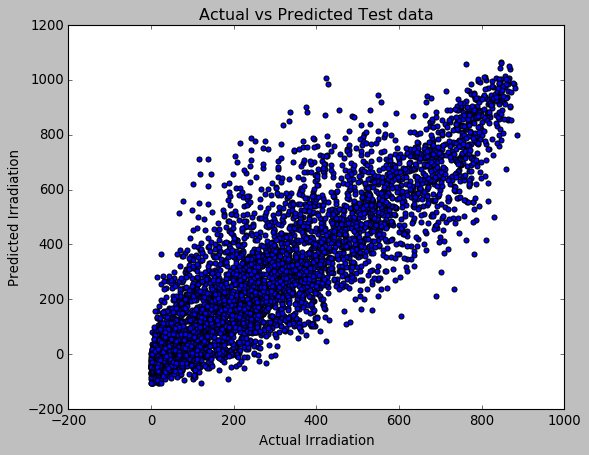

In [13]:
slope, intercept = stats.linregress(Y_test.values.reshape((len(Y_test),)), predictions.reshape((len(Y_test),)))[0:2]

print("Slope and intercept of the regression model between predicted and actual Irradiation: ", slope, intercept)

predictions = (predictions-intercept)/slope

plt.scatter(Y_test, predictions)
plt.xlabel('Actual Irradiation')
plt.ylabel('Predicted Irradiation')
plt.title('Actual vs Predicted Test data')
plt.style.use(['classic'])

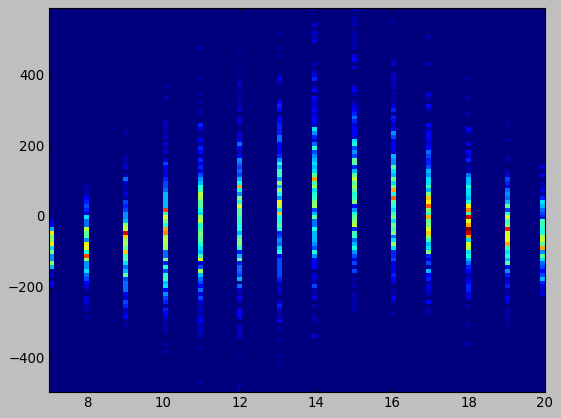

In [14]:
residuals = predictions.reshape((len(Y_test),)) - Y_test.values.reshape((len(Y_test),))
hours = X_test.values[:,0]

plt.hist2d(hours, residuals, bins=100)
plt.show()

**Errors are distributed over all hours.**

The intention was to find out if the predictions are worse for any particular hour of the day which could have then been dropped. However, this does not seem to be the case.

(array([   6.,   47.,  296., 1146., 1559.,  879.,  322.,  110.,   40.,
          19.]),
 array([-494.54104553, -385.73788434, -276.93472314, -168.13156195,
         -59.32840076,   49.47476044,  158.27792163,  267.08108282,
         375.88424402,  484.68740521,  593.49056641]),
 <a list of 10 Patch objects>)

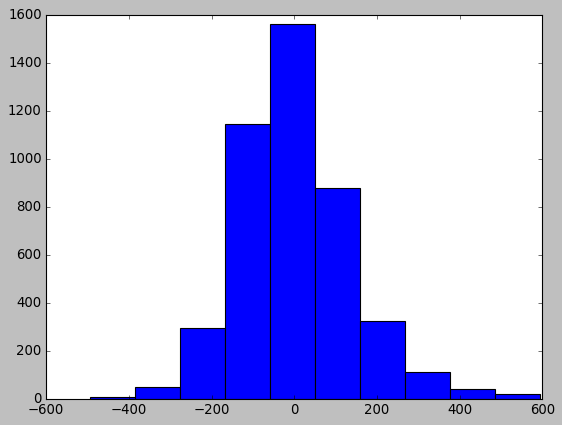

In [15]:
plt.style.use(['classic'])
plt.hist(residuals)

In [20]:
#Save the trained model

#model.save('Trained.h5')